In [1]:
%load_ext zipline

In [10]:
import pandas as pd
from collections import OrderedDict
import pytz
from zipline.api import order, record, symbol, set_benchmark, order_target_percent, get_open_orders
import zipline
from datetime import datetime
from zipline.utils.calendars.exchange_calendar_twentyfourhr import TwentyFourHR

In [11]:
data = OrderedDict()
data['BTC'] = pd.read_csv("BTC-USD.csv")

data['BTC']['date'] = pd.to_datetime(data['BTC']['time'], unit='s', utc=True) # unix time to datetime, second interval, utc time zone
data['BTC'].set_index('date', inplace=True)
data['BTC'].drop('time', axis=1, inplace=True)

# fill in missing data
data['BTC'] = data['BTC'].resample("1min").mean() 
data['BTC'].fillna(method="ffill", inplace=True)

data['BTC'] = data['BTC'][["low","high","open","close","volume"]]
print(data['BTC'].head())

panel = pd.Panel(data)
panel.minor_axis = ["low","high","open","close","volume"]
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

                             low         high         open        close  \
date                                                                      
2018-02-05 17:48:00  7170.000000  7171.000000  7170.000000  7170.990234   
2018-02-05 17:49:00  7131.990234  7171.000000  7170.990234  7131.990234   
2018-02-05 17:50:00  7120.000000  7137.359863  7132.000000  7120.020020   
2018-02-05 17:51:00  7113.000000  7121.000000  7120.040039  7113.000000   
2018-02-05 17:52:00  7113.000000  7122.000000  7113.000000  7121.990234   

                        volume  
date                            
2018-02-05 17:48:00   3.425961  
2018-02-05 17:49:00   5.209975  
2018-02-05 17:50:00  14.767619  
2018-02-05 17:51:00  18.237879  
2018-02-05 17:52:00  22.768671  
<class 'pandas.core.panel.Panel'>
Dimensions: 1 (items) x 72277 (major_axis) x 5 (minor_axis)
Items axis: BTC to BTC
Major_axis axis: 2018-02-05 17:48:00+00:00 to 2018-03-27 22:24:00+00:00
Minor_axis axis: low to volume


In [12]:
def initialize(context):
    set_benchmark(symbol("BTC"))


def handle_data(context, data):

    slowma = data.history(symbol("BTC"), fields='price', bar_count=50, frequency='1m').mean()
    fastma = data.history(symbol("BTC"), fields='price', bar_count=10, frequency='1m').mean()

    if fastma < slowma:
        if symbol("BTC") not in get_open_orders():
            order_target_percent(symbol("BTC"), 0.04)

    if fastma > slowma:
        if symbol("BTC") not in get_open_orders():
            order_target_percent(symbol("BTC"), 0.96)

    record(BTC=data.current(symbol('BTC'), fields='price'))

In [16]:
perf = zipline.run_algorithm(start=datetime(2018, 2, 7, 0, 0, 0, 0, pytz.utc),
                      end=datetime(2018, 3, 26, 0, 0, 0, 0, pytz.utc),
                      initialize=initialize,
                      trading_calendar=TwentyFourHR(),
                      capital_base=10000,
                      handle_data=handle_data,
                      data_frequency ='minute',
                      data=panel)

In [17]:
perf.head()

,BTC,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2018-02-07 23:59:00+00:00,7575.750000,NaN,-0.004564,NaN,-0.014660,NaN,NaN,-7621.389868,2378.610132,7575.750000,...,0.0,0.0,0,NaN,10000.000000,0.000000,0.000000,1,"[{'dt': 2018-02-07 00:12:00+00:00, 'price': 76...",0.0
2018-02-08 23:59:00+00:00,8218.099609,0.775572,0.059671,1.416463,0.068888,1.116323,0.694756,0.000000,2378.610132,8218.099609,...,0.0,0.0,0,147.483097,2378.610132,7575.750000,7575.750000,2,[],0.0
2018-02-09 23:59:00+00:00,8671.009766,0.560739,0.104962,1.349786,0.127795,0.810458,0.691759,0.000000,2378.610132,8671.009766,...,0.0,0.0,0,206.248886,2378.610132,8218.099609,8218.099609,3,[],0.0
2018-02-10 23:59:00+00:00,8547.490234,0.582711,0.092610,0.669551,0.111730,0.797126,0.728847,0.000000,2378.610132,8547.490234,...,0.0,0.0,0,60.166627,2378.610132,8671.009766,8671.009766,4,[],0.0
2018-02-11 23:59:00+00:00,8072.990234,0.690126,0.045160,0.306181,0.050014,0.908825,0.757423,0.000000,2378.610132,8072.990234,...,0.0,0.0,0,7.575565,2378.610132,8547.490234,8547.490234,5,[],0.0


In [18]:
import zipline
zipline.__file__

'C:\\Users\\user\\Anaconda3\\envs\\tensorflow\\lib\\site-packages\\zipline\\__init__.py'

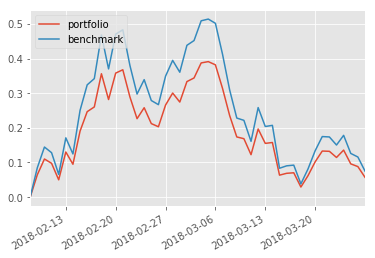

In [19]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

perf.portfolio_value.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='portfolio')
perf.BTC.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='benchmark')
plt.legend(loc=2)

plt.show()